# Neural Network Grid Search

### CISC 351 - Data Analytics
### Marshall Ruse, 1006 6247

This notebook implements a gridsearch to tune some of the hyperparameters for the neural networks prediciting default in the Kaggle Home Credit Default Challenge.  The networks are implemented using Keras, an Imbalance Learn pipeline, and Sklearn's GridsearchCV function.

In [1]:
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install sklearn --upgrade
#!pip install psutil --upgrade
#!pip install gcsfs
#!pip install keras
#!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/38/7f/7d21bd89a97603a14d3770ca912d4402c394a8e50642f9b8b5cc6867a61a/scikit_learn-0.20.3-cp35-cp35m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [33]:
import numpy as np
import pandas as pd
import gcsfs
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import (roc_auc_score, 
                             roc_curve, 
                             auc,
                             make_scorer)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
pd.__version__

'0.24.2'

In [3]:
featMatTrain = pd.read_csv('gs://final-project-235702/featureMatrix_prepared_TRAIN.csv',index_col='SK_ID_CURR')
featMatTest = pd.read_csv('gs://final-project-235702/featureMatrix_prepared_TEST.csv',index_col='SK_ID_CURR')
testingLabels = pd.read_csv('gs://final-project-235702/testing_labels.csv',index_col=0)
featMatTrain.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT(POSCash),COUNT(bureau),COUNT(bureauBalance),COUNT(creditCard),...,Loan amount / total income,Annuity amount / total income,Total debt / total income,Loan / total goods price,Total external credit limits,Current yearly payment pre,Growth in loan size (sparse) (0 if microfinance) over previous loan,Important Income - yearly credit payments (free cash flow),Years to pay back loan,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,24700.5,406597.5,351000.0,202500.0,0,True,19.0,8.0,110.0,0.0,...,2.007889,1.463733,6.279768,1.158397,865055.564,7946.5547,0.440374,175460.718282,1.371759,1.0
100003,35698.5,1293502.5,1129500.0,270000.0,1,False,28.0,4.0,0.0,0.0,...,4.790750,1.586600,8.558900,1.145199,1017400.500,76889.0000,0.800835,177358.180649,3.019507,0.0
100004,6750.0,135000.0,135000.0,67500.0,0,True,4.0,2.0,0.0,0.0,...,2.000000,1.200000,4.800560,1.000000,189037.800,25096.4430,2.582500,178774.753985,1.666667,0.0
100006,29686.5,312682.5,297000.0,135000.0,1,False,21.0,0.0,0.0,6.0,...,2.316167,2.638800,5.425926,1.052803,146250.000,15037.8590,0.217644,178809.249050,0.877735,0.0
100007,21865.5,513000.0,513000.0,121500.0,0,True,66.0,1.0,0.0,0.0,...,4.222222,2.159556,9.686273,1.000000,468445.500,38998.4570,0.039193,178840.994296,1.955135,0.0


In [4]:
featMatTest.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT(POSCash),COUNT(bureau),COUNT(bureauBalance),COUNT(creditCard),...,Loan amount / total income,Annuity amount / total income,Total debt / total income,Loan / total goods price,Total external credit limits,Current yearly payment pre,Growth in loan size (sparse) (0 if microfinance) over previous loan,Important Income - yearly credit payments (free cash flow),Years to pay back loan,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
157878,40167.0,945000.0,945000.0,247500.0,0,True,0.0,3.0,152.0,0.0,...,3.818182,1.947491,11.399428,1.000000,865055.564,7946.5547,0.189476,170999.537794,1.960565,NaN
157879,27000.0,540000.0,540000.0,180000.0,0,True,0.0,1.0,0.0,0.0,...,3.000000,1.800000,11.399428,1.000000,1017400.500,76889.0000,1.918300,170999.537794,1.666667,NaN
157880,16011.0,295168.5,238500.0,112500.0,1,False,0.0,4.0,77.0,32.0,...,2.623720,1.707840,11.399428,1.237604,189037.800,25096.4430,1.181147,170999.537794,1.536280,NaN
157881,17266.5,298512.0,270000.0,63000.0,1,False,0.0,0.0,0.0,0.0,...,4.738286,3.288857,11.399428,1.105600,146250.000,15037.8590,0.227976,170999.537794,1.440709,NaN
157882,24259.5,640080.0,450000.0,67500.0,1,False,0.0,11.0,0.0,0.0,...,9.482667,4.312800,11.399428,1.422400,468445.500,38998.4570,0.031412,170999.537794,2.198726,NaN


Some preprocessing to normalize the floating point columns and convert the boolean columns to numeric.

In [4]:
for col in featMatTrain:
  
  if featMatTrain[col].dtype == 'bool':
    featMatTrain[col] = featMatTrain[col].astype(int)
    
  if (featMatTrain[col].dtype == 'float64') and (col != 'TARGET'):
    if featMatTrain[col].std() != 0:
      featMatTrain[col] = (featMatTrain[col] - featMatTrain[col].mean()) / featMatTrain[col].std()
    else:
      featMatTrain[col] = (featMatTrain[col] - featMatTrain[col].mean())
    
for col in featMatTest:
  
  if featMatTest[col].dtype == 'bool':
    featMatTest[col] = featMatTest[col].astype(int)
    
  if (featMatTest[col].dtype == 'float64') and (col != 'TARGET'):
    if featMatTest[col].std() != 0:
      featMatTest[col] = (featMatTest[col] - featMatTest[col].mean()) / featMatTest[col].std()
    else:
      featMatTest[col] = (featMatTest[col] - featMatTest[col].mean())

Edit the column names because Keras doesn't like some of the symbols.

In [5]:
featMatTrain.columns = featMatTrain.columns.str.replace(" ","_")
featMatTrain.columns = featMatTrain.columns.str.replace(":","_")
featMatTrain.columns = featMatTrain.columns.str.replace("(","_")
featMatTrain.columns = featMatTrain.columns.str.replace(")","_")
featMatTrain.columns = featMatTrain.columns.str.replace("+","_")
featMatTrain.columns = featMatTrain.columns.str.replace(",","_")
featMatTrain.columns = featMatTrain.columns.str.replace(".","_")

featMatTest.columns = featMatTest.columns.str.replace(" ","_")
featMatTest.columns = featMatTest.columns.str.replace(":","_")
featMatTest.columns = featMatTest.columns.str.replace("(","_")
featMatTest.columns = featMatTest.columns.str.replace(")","_")
featMatTest.columns = featMatTest.columns.str.replace("+","_")
featMatTest.columns = featMatTest.columns.str.replace(",","_")
featMatTest.columns = featMatTest.columns.str.replace(".","_")

Drop the Target column in the testing set, its all NaNs, and the labels were imported seperately as testingLabels.

In [6]:
featMatTest.drop('TARGET',axis=1, inplace=True)

Drop the couple rows with missing values.

In [7]:
featMatTest.dropna(axis=0, inplace=True)

In [9]:
featMatTest.shape

(4869, 639)

In [65]:
featMatTest.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CODE_GENDER_F,CODE_GENDER_M,COUNT_POSCash_,COUNT_bureau_,COUNT_bureauBalance_,COUNT_creditCard_,...,SUM_prevApps_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_,Loan_amount_/_total_income,Annuity_amount_/_total_income,Total_debt_/_total_income,Loan_/_total_goods_price,Total_external_credit_limits,Current_yearly_payment_pre,Growth_in_loan_size__sparse___0_if_microfinance__over_previous_loan,Important_Income_-_yearly_credit_payments__free_cash_flow_,Years_to_pay_back_loan
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
157878,0.877614,0.834430,1.069478,0.904341,0,1,0.0,-0.387000,0.938472,-0.385552,...,-0.564303,-0.069618,-0.207700,0.999897,-1.006208,-0.310454,-0.708695,-0.290962,0.0,0.236055
157879,-0.012322,-0.155970,-0.006499,0.153904,0,1,0.0,-0.834921,-0.402480,-0.385552,...,0.978621,-0.370183,-0.338798,0.999897,-1.006208,-0.265103,-0.120116,1.184751,0.0,-0.215739
157880,-0.755052,-0.754689,-0.807503,-0.596533,1,0,0.0,-0.163039,0.276818,1.307599,...,-0.564303,-0.508412,-0.420716,0.999897,0.940478,-0.511699,-0.562282,0.555522,0.0,-0.416176
157881,-0.670194,-0.746513,-0.723816,-1.146854,1,0,0.0,-1.058881,-0.402480,-0.385552,...,0.207159,0.268389,0.984586,0.999897,-0.141028,-0.524436,-0.648155,-0.258099,0.0,-0.563092
157882,-0.197548,0.088769,-0.245605,-1.096825,1,0,0.0,1.404684,-0.402480,-0.385552,...,1.750083,2.011270,1.894726,0.999897,2.454511,-0.428522,-0.443597,-0.425885,0.0,0.602169


The model to be wrapped by KerasClassifier, used in the Gridsearch

In [8]:
def create_model(output_dim_1=128,
                 output_dim_2=64,
                 output_dim_3=32,
                 output_dim_4=16,
                 regularizer=regularizers.l1,
                 regularizer_rate=0.001,
                 learning_rate=0.001):
  model = Sequential()
  model.add(Dense(output_dim_1, input_dim=featMatTest.shape[1], activation='relu',kernel_regularizer=regularizer(regularizer_rate)))
  model.add(Dense(output_dim_2,  activation='relu',kernel_regularizer=regularizer(regularizer_rate)))
  model.add(Dense(output_dim_3,  activation='relu',kernel_regularizer=regularizer(regularizer_rate)))
  model.add(Dense(output_dim_4,  activation='relu',kernel_regularizer=regularizer(regularizer_rate)))
  model.add(Dense(1, activation='sigmoid'))
  
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=[metrics.binary_accuracy])
  return model

In [9]:
model = KerasClassifier(build_fn=create_model, verbose=0)

The hyperparameters to be tested:

In [10]:
batch_size = [32, 64, 128, 256]
epochs = [10, 15]
#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)]
output_dim_1 = [16, 32, 64, 128]
output_dim_2 = [16, 32, 64, 128]
output_dim_3 = [16, 32]
output_dim_4 = [16, 32]
regularizer = [regularizers.l1, regularizers.l2]
regularizer_rate = [0.001, 0.003, 0.01]
learning_rate = [0.001]
param_grid = dict(clf__batch_size=batch_size,
                  clf__epochs=epochs,
                  clf__output_dim_1=output_dim_1,
                  clf__output_dim_2=output_dim_2,
                  clf__output_dim_3=output_dim_3,
                  clf__output_dim_4=output_dim_4,
                  clf__regularizer=regularizer,
                  clf__regularizer_rate=regularizer_rate,
                  clf__learning_rate=learning_rate )

Do the upsampling via SMOTE in a pipeline, so that the training set is upsampled seperately from the validation set.

In [11]:
pipe = imbPipeline([
    ('oversample', SMOTE(random_state=444)),
    ('clf', model)
    ])

skf = StratifiedKFold()

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The metrics to be tracked during training:

In [12]:
scoring = {'AUC': 'roc_auc', 'binary_accuracy': 'balanced_accuracy', 'precision': 'precision', 'recall': 'recall'}

In [13]:
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, refit='AUC', n_jobs=-1, cv=skf, verbose=10)

In [ ]:
grid_result = grid.fit(featMatTrain.drop('TARGET', axis=1), featMatTrain['TARGET'])

Fitting 3 folds for each of 3072 candidates, totalling 9216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  8.7min
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarni

In [19]:
print("BEST: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    print("")

BEST: 0.640293 using {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 16, 'clf__batch_size': 64, 'clf__epochs': 10, 'clf__output_dim_1': 16, 'clf__output_dim_2': 16, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.551069 (0.040045) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 16, 'clf__batch_size': 16, 'clf__epochs': 5, 'clf__output_dim_1': 16, 'clf__output_dim_2': 16, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.597420 (0.009330) with: {'clf__regularizer_rate': 0.003, 'clf__output_dim_4': 16, 'clf__batch_size': 16, 'clf__epochs': 5, 'clf__output_dim_1': 16, 'clf__output_dim_2': 16, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.594686 (0.013736) with: {'clf__regularizer_rate': 0.01, 'clf__output_dim_4': 16, 'clf__batch_size': 16, 'clf__epochs': 5, 'clf__output_dim_1': 16, 'clf__output_dim_2': 16, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.595358 (0.005574) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 32, '

0.546579 (0.035131) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 16, 'clf__batch_size': 32, 'clf__epochs': 5, 'clf__output_dim_1': 64, 'clf__output_dim_2': 128, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.601206 (0.007421) with: {'clf__regularizer_rate': 0.003, 'clf__output_dim_4': 16, 'clf__batch_size': 32, 'clf__epochs': 5, 'clf__output_dim_1': 64, 'clf__output_dim_2': 128, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.597824 (0.010382) with: {'clf__regularizer_rate': 0.01, 'clf__output_dim_4': 16, 'clf__batch_size': 32, 'clf__epochs': 5, 'clf__output_dim_1': 64, 'clf__output_dim_2': 128, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.542633 (0.061977) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 32, 'clf__batch_size': 32, 'clf__epochs': 5, 'clf__output_dim_1': 64, 'clf__output_dim_2': 128, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.599725 (0.007925) with: {'clf__regularizer_rate': 0.003, 'clf__output_dim_4

0.602569 (0.006939) with: {'clf__regularizer_rate': 0.01, 'clf__output_dim_4': 32, 'clf__batch_size': 64, 'clf__epochs': 5, 'clf__output_dim_1': 128, 'clf__output_dim_2': 16, 'clf__output_dim_3': 32, 'clf__learning_rate': 0.001}

0.509243 (0.013071) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4': 16, 'clf__batch_size': 64, 'clf__epochs': 5, 'clf__output_dim_1': 128, 'clf__output_dim_2': 32, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.524504 (0.022151) with: {'clf__regularizer_rate': 0.003, 'clf__output_dim_4': 16, 'clf__batch_size': 64, 'clf__epochs': 5, 'clf__output_dim_1': 128, 'clf__output_dim_2': 32, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.580056 (0.026970) with: {'clf__regularizer_rate': 0.01, 'clf__output_dim_4': 16, 'clf__batch_size': 64, 'clf__epochs': 5, 'clf__output_dim_1': 128, 'clf__output_dim_2': 32, 'clf__output_dim_3': 16, 'clf__learning_rate': 0.001}

0.560029 (0.018588) with: {'clf__regularizer_rate': 0.001, 'clf__output_dim_4'

In [22]:
grid_result.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

Align the testing labels with the test set, as some rows were dropped in the test set.

In [71]:
featMatTest, testingLabels = featMatTest.align(testingLabels, axis=0, join='inner')

In [72]:
grid_result.score(featMatTest, testingLabels)

0.5888776539693381

In [15]:
print("BEST: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    print("")

BEST: 0.697437 using {'clf__regularizer_rate': 0.001, 'clf__output_dim_3': 32, 'clf__batch_size': 256, 'clf__output_dim_2': 64, 'clf__regularizer': <function l2 at 0x7fdaa5c650d0>, 'clf__learning_rate': 0.001, 'clf__output_dim_1': 16, 'clf__epochs': 15, 'clf__output_dim_4': 16}



KeyError: 'mean_test_score'

In [40]:
grid_result.score(featMatTest, testingLabels)

0.6869012988950336

In [42]:
list(grid_result.cv_results_.keys())

['param_clf__output_dim_4',
 'split0_test_precision',
 'split0_train_recall',
 'param_clf__epochs',
 'mean_test_precision',
 'split2_train_binary_accuracy',
 'mean_train_recall',
 'mean_train_precision',
 'mean_train_AUC',
 'std_train_AUC',
 'split2_train_AUC',
 'param_clf__output_dim_2',
 'split0_train_binary_accuracy',
 'split1_test_precision',
 'split1_test_AUC',
 'split1_train_precision',
 'split2_train_precision',
 'split1_train_recall',
 'split2_test_recall',
 'std_train_binary_accuracy',
 'param_clf__output_dim_3',
 'param_clf__learning_rate',
 'rank_test_binary_accuracy',
 'split1_test_binary_accuracy',
 'std_test_binary_accuracy',
 'split0_test_AUC',
 'split1_train_binary_accuracy',
 'split2_train_recall',
 'param_clf__regularizer_rate',
 'split1_train_AUC',
 'std_train_recall',
 'rank_test_precision',
 'mean_score_time',
 'split0_test_recall',
 'mean_test_recall',
 'split1_test_recall',
 'mean_test_binary_accuracy',
 'param_clf__output_dim_1',
 'std_test_AUC',
 'rank_test_rec

In [46]:
grid_result.cv_results_['mean_test_recall'].max()

1.0

### Individually test the best model, see if refinements can be made

In [17]:
def SMOTEUpSample(trainDF):
  
  trainDFCols = list(trainDF.columns)
  trainDFCols.remove('TARGET')
  sm = SMOTE(random_state=12, ratio=1.0)
  x_train_res, y_train_res = sm.fit_sample(trainDF.drop('TARGET', axis=1), trainDF['TARGET'])
  
  upSampDF = pd.DataFrame(x_train_res, columns=trainDFCols)
  upSampDF['TARGET'] = pd.Series(y_train_res)
  
  return upSampDF

In [21]:
from sklearn.model_selection import train_test_split

featMatTrainTrain, featMatTrainVal = train_test_split(featMatTrain, test_size=0.2)

featMatTrainTrainUpSamp = SMOTEUpSample(featMatTrainTrain)

Keras no longer supports precision and recall as metrics to be tracked, so create functions to implement it

In [16]:
import keras.backend as K

def precision(y_true, y_pred):
    """Precision metric.	
     Only computes a batch-wise average of precision.	
     Computes the precision, a metric for multi-label classification of	
    how many selected items are relevant.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision
  
def recall(y_true, y_pred):
    """Recall metric.	
     Only computes a batch-wise average of recall.	
     Computes the recall, a metric for multi-label classification of	
    how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

In [22]:
bestModel = Sequential()
bestModel.add(Dense(16, input_dim=featMatTest.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel.add(Dense(64,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel.add(Dense(32,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel.add(Dense(16,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel.add(Dense(1, activation='sigmoid'))

bestModel.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=[metrics.binary_accuracy, precision, recall])

bestModel.fit(featMatTrainTrainUpSamp.drop('TARGET', axis=1), featMatTrainTrainUpSamp['TARGET'],
              epochs=15,
              batch_size=256,
              validation_data=(featMatTrainVal.drop('TARGET', axis=1), featMatTrainVal['TARGET']))


Train on 45294 samples, validate on 6151 samples
Epoch 1/15
45294/45294 [==============================] - 4s 82us/step - loss: 3.6637 - binary_accuracy: 0.5163 - precision: 0.5182 - recall: 0.7126 - val_loss: 3.2046 - val_binary_accuracy: 0.6576 - val_precision: 0.1113 - val_recall: 0.4505
Epoch 2/15
45294/45294 [==============================] - 3s 67us/step - loss: 2.0673 - binary_accuracy: 0.5837 - precision: 0.5751 - recall: 0.6890 - val_loss: 3.1879 - val_binary_accuracy: 0.6592 - val_precision: 0.1253 - val_recall: 0.5157
Epoch 3/15
45294/45294 [==============================] - 3s 68us/step - loss: 2.0733 - binary_accuracy: 0.5927 - precision: 0.5837 - recall: 0.7031 - val_loss: 3.2982 - val_binary_accuracy: 0.5324 - val_precision: 0.1237 - val_recall: 0.7597
Epoch 4/15
45294/45294 [==============================] - 3s 64us/step - loss: 2.0853 - binary_accuracy: 0.6037 - precision: 0.5881 - recall: 0.7141 - val_loss: 3.0760 - val_binary_accuracy: 0.7140 - val_precision: 0.1141 

In [27]:
featMatTest, testingLabels = featMatTest.align(testingLabels, axis=0, join='inner')

In [28]:
test_scores = bestModel.evaluate(featMatTest, testingLabels)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

4868/4868 [==============================] - 0s 40us/step
Accuracy:  0.3742810188989318
Precision:  0.10443196525902854  Recall:  0.803998883277937


In [32]:
y_pred = bestModel.predict(featMatTest)


In [35]:
def makeROCCurve(y_true, y_pred):
  
  falsePosRate, truePosRate, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(falsePosRate, truePosRate)
  
  fig, ax = plt.subplots(figsize=(10,10))
  lw = 2
  ax.plot(falsePosRate, truePosRate, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  
  ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')
  ax.legend(loc="lower right")
  plt.show()
  

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


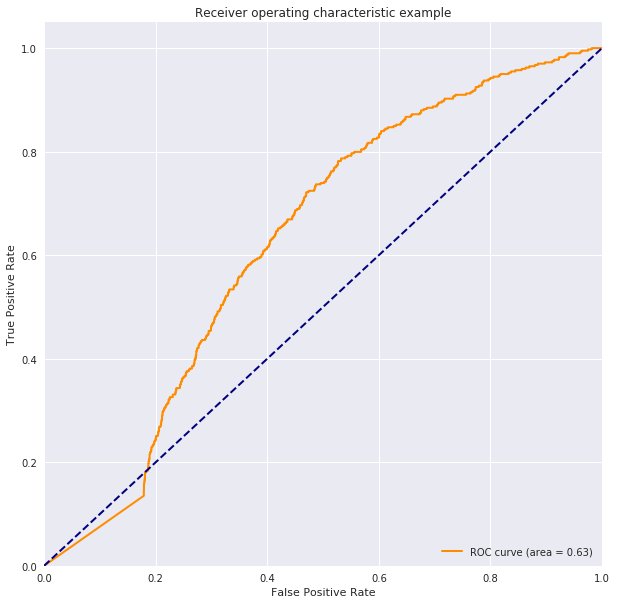

In [36]:
makeROCCurve(np.array(testingLabels), y_pred)

In [37]:
bestModel2 = Sequential()
bestModel2.add(Dense(16, input_dim=featMatTest.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel2.add(Dense(64,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel2.add(Dense(32,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel2.add(Dense(16,  activation='relu',kernel_regularizer=regularizers.l2(0.001)))
bestModel2.add(Dense(1, activation='sigmoid'))

bestModel2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0005), metrics=[metrics.binary_accuracy, precision, recall])

bestModel2.fit(featMatTrainTrainUpSamp.drop('TARGET', axis=1), featMatTrainTrainUpSamp['TARGET'],
              epochs=100,
              batch_size=256,
              validation_data=(featMatTrainVal.drop('TARGET', axis=1), featMatTrainVal['TARGET']))

Train on 45294 samples, validate on 6151 samples
Epoch 1/100
45294/45294 [==============================] - 4s 79us/step - loss: 6.5590 - binary_accuracy: 0.5070 - precision: 0.1027 - recall: 0.1126 - val_loss: 0.5649 - val_binary_accuracy: 0.9159 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
45294/45294 [==============================] - 3s 68us/step - loss: 1.6943 - binary_accuracy: 0.5926 - precision: 0.6300 - recall: 0.5481 - val_loss: 0.7844 - val_binary_accuracy: 0.5162 - val_precision: 0.1195 - val_recall: 0.7606
Epoch 3/100
45294/45294 [==============================] - 3s 70us/step - loss: 1.6648 - binary_accuracy: 0.6346 - precision: 0.6651 - recall: 0.5932 - val_loss: 0.7152 - val_binary_accuracy: 0.6814 - val_precision: 0.1547 - val_recall: 0.6400
Epoch 4/100
45294/45294 [==============================] - 3s 63us/step - loss: 1.6492 - binary_accuracy: 0.6530 - precision: 0.6824 - recall: 0.6096 - val_loss: 0.8000 - val_binary_accuracy: 0.5659 - val_precis

45294/45294 [==============================] - 3s 66us/step - loss: 1.5761 - binary_accuracy: 0.7070 - precision: 0.7163 - recall: 0.7030 - val_loss: 0.8133 - val_binary_accuracy: 0.5820 - val_precision: 0.1366 - val_recall: 0.7554
Epoch 68/100
45294/45294 [==============================] - 3s 64us/step - loss: 1.5769 - binary_accuracy: 0.7056 - precision: 0.7170 - recall: 0.6982 - val_loss: 0.6846 - val_binary_accuracy: 0.6797 - val_precision: 0.1623 - val_recall: 0.6871
Epoch 69/100
45294/45294 [==============================] - 3s 68us/step - loss: 1.5754 - binary_accuracy: 0.7076 - precision: 0.7175 - recall: 0.7012 - val_loss: 0.7266 - val_binary_accuracy: 0.6519 - val_precision: 0.1547 - val_recall: 0.7138
Epoch 70/100
45294/45294 [==============================] - 3s 67us/step - loss: 1.5795 - binary_accuracy: 0.7036 - precision: 0.7155 - recall: 0.6966 - val_loss: 0.6735 - val_binary_accuracy: 0.7033 - val_precision: 0.1705 - val_recall: 0.6703
Epoch 71/100
45294/45294 [=======

In [38]:
test_scores = bestModel2.evaluate(featMatTest, testingLabels)
print("Accuracy: ", test_scores[1])
print("Precision: ", test_scores[2], " Recall: ", test_scores[3])

4868/4868 [==============================] - 0s 59us/step
Accuracy:  0.7313064913722268
Precision:  0.165999127639153  Recall:  0.5206636032709452


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


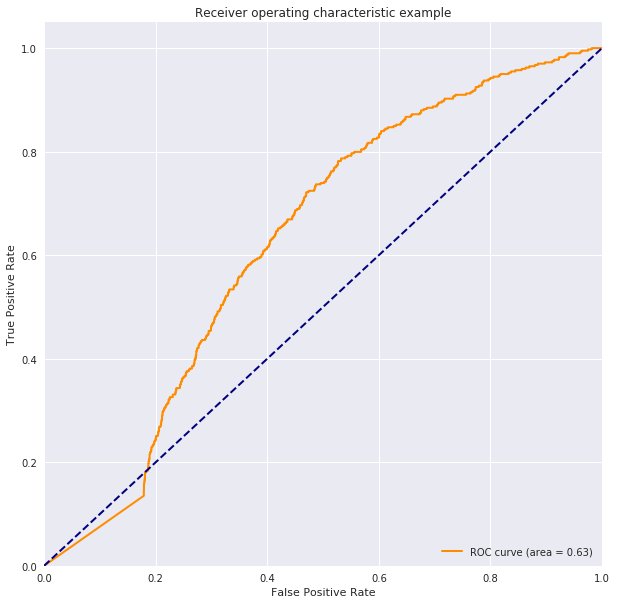

In [39]:
y_pred = bestModel.predict(featMatTest)
makeROCCurve(np.array(testingLabels), y_pred)